<a href="https://colab.research.google.com/github/dnhshl/cc-ai/blob/main/obstsalat3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ein erstes Beispiel zur Klassifikation von Objekten mit neuronalen Netzen
## Apfel, Orange oder Birne?

Dieses Notebook wurde in Anlehnung an
"Is it a bird? Creating a model from your own data" (https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) von Jeremy Howard,(fast.ai—Making neural nets uncool again, https://www.fast.ai/)
erstellt.

DN 12.03.2023

## Vorbereitendes

aktuellste Version der fast.ai Library und duckduckgo_search Library installieren und weitere Libraries importieren.

In [ ]:
!pip install -Uqq fastai
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 11.5 MB/s eta 0:00:00


## Step 1: Daten organisieren.



In [1]:
import zipfile


In [2]:
with zipfile.ZipFile('images.zip', 'r') as zip_ref:
    zip_ref.extractall('./images')


In [31]:

from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

def show_images(images, path='./images/fruits'):
    p = Path(path)
    for image_name in images:
        # Construct the full path to the image
        img_path = p.joinpath(image_name)

        # Open the image and convert it to RGB (if it's not already)
        img = Image.open(img_path).convert('RGB')

        # Resize the image to a thumbnail
        thumb_size = (256, 256)
        img.thumbnail(thumb_size)

        # Display the image
        plt.imshow(img)
        plt.title(image_name)
        plt.show()


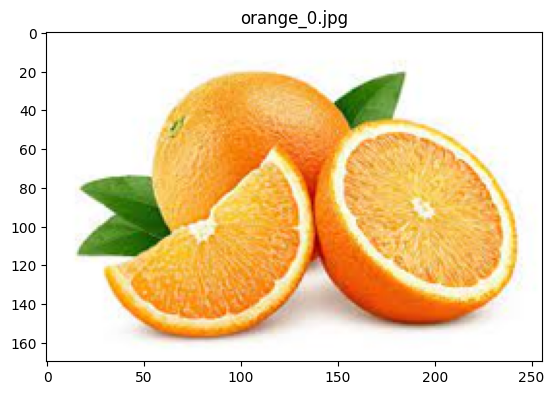

In [33]:
images = ['orange_' + str(i)+ '.jpg' for i in range(1)]
show_images(images, path='./test')

## Step 2: Das Modell trainieren

Anmerkung: die nachfolgenden Punkte sind eins-zu-eins aus dem fast.ai Notebook übernommen und daher auf Englisch kommentiert.

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

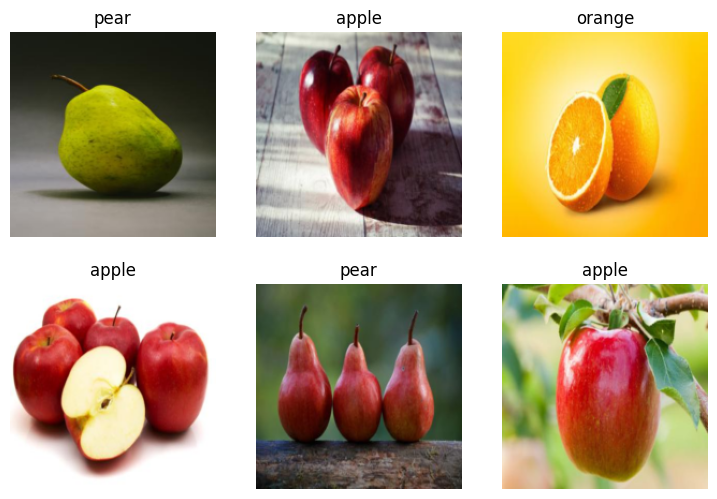

In [24]:
from fastai.vision.all import *
from fastai.data.block import *

classes = 'apple','orange', 'pear'
path = Path('./images/fruits')

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files,

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [39]:
model = vision_learner(dls, resnet18, metrics=error_rate)
model.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,time
0,2.155620,0.855804,0.346154,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.811922,0.543517,0.230769,00:00
1,0.576481,0.396583,0.153846,00:00
2,0.462113,0.347308,0.115385,00:00
3,0.372866,0.344772,0.153846,00:00
4,0.300237,0.332686,0.153846,00:00
5,0.251005,0.344283,0.153846,00:00
6,0.209904,0.377521,0.192308,00:00
7,0.178840,0.379172,0.153846,00:00
8,0.154562,0.389354,0.153846,00:00
9,0.134882,0.409660,0.192308,00:00


## Step 3: Das trainierte Modell anwenden

Wir prüfen, wie unser Modell die Beispielbilder klassifiziert, die wir am Anfang geladen haben.

This is a: apple.
Probability it's apple: 0.7439
tensor([0.7439, 0.0098, 0.2464])


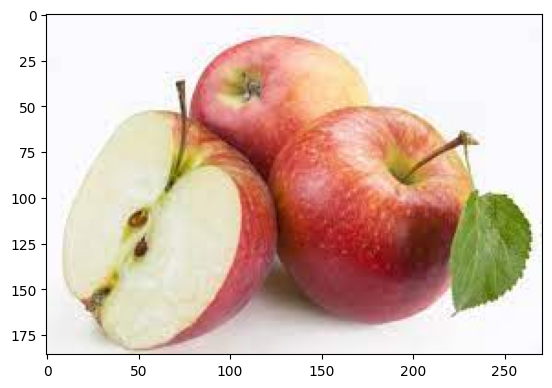

This is a: pear.
Probability it's pear: 0.9045
tensor([0.0746, 0.0209, 0.9045])


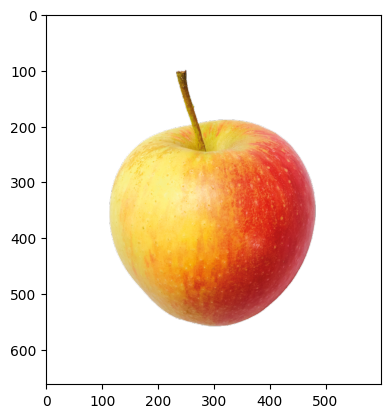

This is a: pear.
Probability it's pear: 0.9992
tensor([2.1189e-04, 6.1532e-04, 9.9917e-01])


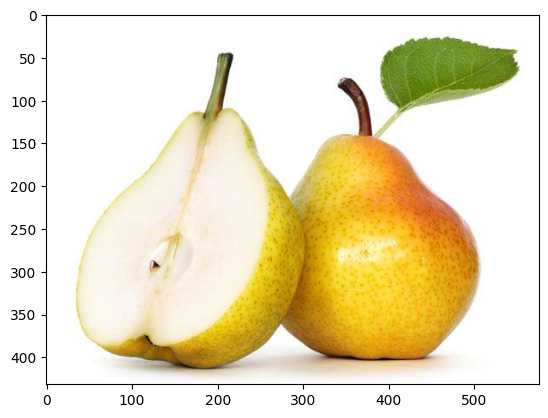

This is a: apple.
Probability it's apple: 0.9572
tensor([9.5722e-01, 2.8519e-04, 4.2498e-02])


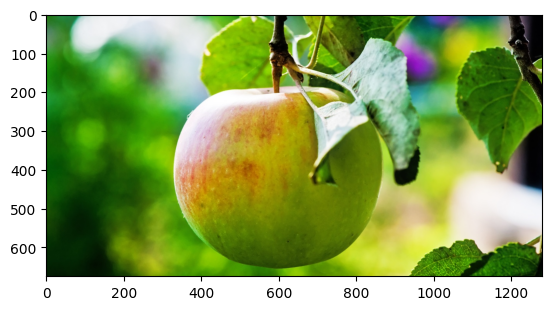

This is a: pear.
Probability it's pear: 0.9986
tensor([2.1769e-04, 1.1468e-03, 9.9864e-01])


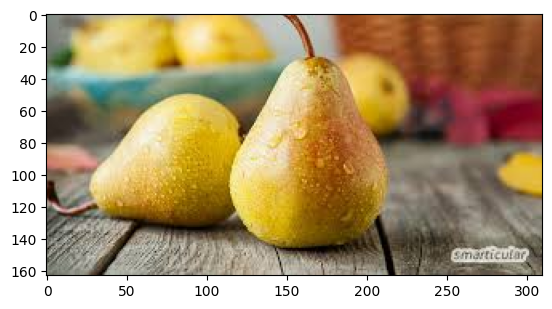

This is a: orange.
Probability it's orange: 0.9992
tensor([3.7875e-06, 9.9917e-01, 8.2636e-04])


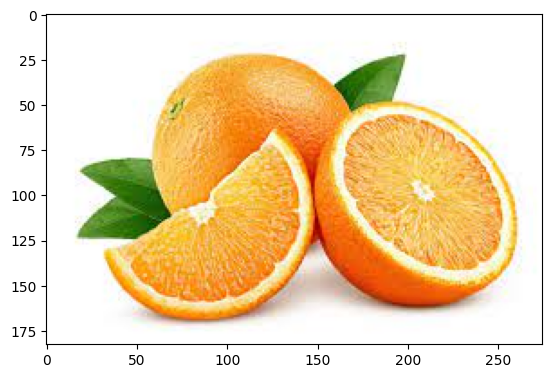

In [40]:
p = Path('./test')
images = p.glob('*.jpg')

for image in images:
    is_fruit,_,probs = model.predict(image)
    print(f"This is a: {is_fruit}.")
    idx = list(model.dls.vocab).index(is_fruit)
    print(f"Probability it's {is_fruit}: {probs[idx]:.4f}")
    print(probs)
    plt.imshow(Image.open(image))
    plt.show()

Wie gut ist unser Modell insgesamt? Wir prüfen die Konfusionsmatrix für die Validierungsdaten.

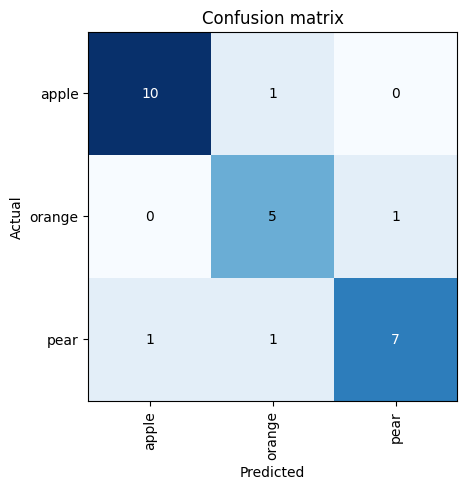

In [41]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

## Step 4: Daten und Modell sichern
### Daten sichern

In [22]:
!ls .

images	images.zip  sample_data  test


### Modell sichern und downloaden

In [ ]:
model.export()

In [ ]:
files.download('export.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>